In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
hse_df = pd.read_json("parsed_results/hse_data.json", orient="records")
itmo_df = pd.read_json("parsed_results/itmo_data.json", orient="records")

In [3]:
hse_df.head(n=1)

,title,educational_programme,year,abstract,level,faculty
0,Разработка программы управленческих действий п...,Управление образованием,2016,\n\tТема исследования: Разработка программы уп...,(Магистратура),Институт образования


In [4]:
itmo_df.head(n=1)

,title,educational_programme,year,abstract,level,faculty
0,РАЗРАБОТКА МЕТОДА УДАЛЕНИЯ ОШИБОК ИЗ НАБОРА ЧТ...,010500 Прикладная математика и информатика,2011,Введение. Многие современные задачи биологии и...,бакалавр,Факультет информационных технологий и программ...


## clear data

In [5]:
def has_no_numbers(text: str) -> bool:
    return not any(char.isdigit() for char in text)

assert has_no_numbers("hello!!!")
assert not has_no_numbers("123")
assert not has_no_numbers("HELLO 123")
assert has_no_numbers("")

In [6]:
def take_text_titles(df: pd.DataFrame) -> pd.DataFrame:
    return df.loc[df["title"].map(has_no_numbers)]

In [7]:
for df in [hse_df, itmo_df]:
    print(f"before filter: {len(df)}, after filter: {len(take_text_titles(df))}")

before filter: 47221, after filter: 44538
before filter: 1561, after filter: 1458


In [8]:
def remove_numbers(text: str) -> str:
    return "".join(filter(lambda char: not char.isdigit(), text))

assert remove_numbers("hello") == "hello"
assert remove_numbers("1231923") == ""
assert remove_numbers("hello 123") == "hello "
assert remove_numbers("") == ""

In [9]:
def apply_to_column(df: pd.DataFrame, function, column: str) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy[column] = df_copy[column].map(function)
    return df_copy

In [10]:
for df in [hse_df, itmo_df]:
    transformed_df = apply_to_column(df, remove_numbers, column="educational_programme")
    changed_num = (df["educational_programme"] != transformed_df["educational_programme"]).sum()
    print(f"Changed {changed_num}")

Changed 0
Changed 1560


In [11]:
def unify_level(level: str) -> str:
    if "бакалавр" in level.lower():
        return "bachelor"
    elif "магистр" in level.lower():
        return "master"
    else:
        return "unknown"
    
assert unify_level("(БаКаЛаВрИаТ)") == "bachelor"
assert unify_level("Магистр") == "master"
assert unify_level("Йожик") == "unknown"

In [12]:
for df in [hse_df, itmo_df]:
    transformed_df = apply_to_column(df, unify_level, column="level")
    print(transformed_df["level"].value_counts())

bachelor    28932
master      17711
unknown       578
Name: level, dtype: int64
master      784
bachelor    507
unknown     270
Name: level, dtype: int64


In [13]:
def remove_punctuation(text: str, whitelisted_symbols=(",", " ")) -> str:
    return "".join(filter(lambda char: char.isalpha() or char in whitelisted_symbols, text))

assert remove_punctuation("hello!!!") == "hello"
assert remove_punctuation("hello, mister freeman") == "hello, mister freeman"
assert remove_punctuation("1*&@!#80123890") == ""

In [14]:
def final_transform(df: pd.DataFrame) -> pd.DataFrame:
    df = take_text_titles(df)
    df = apply_to_column(df, remove_numbers, column="educational_programme")
    df = apply_to_column(df, unify_level, column="level")
    df = apply_to_column(df, remove_punctuation, column="educational_programme")
    df = apply_to_column(df, lambda text: text.strip(), column="educational_programme")

    return df

In [15]:
transformed_hse_df = final_transform(hse_df)
transformed_itmo_df = final_transform(itmo_df)

print(f"HSE: {len(transformed_hse_df)} rows")
print(f"ITMO: {len(transformed_itmo_df)}")

HSE: 44538 rows
ITMO: 1458


## plot distributions

In [16]:
def plot_year_distriubtion(df: pd.DataFrame, title: str, ax):
    sns.countplot(x="year", data=df, ax=ax, color="b")
    ax.set_title(title)

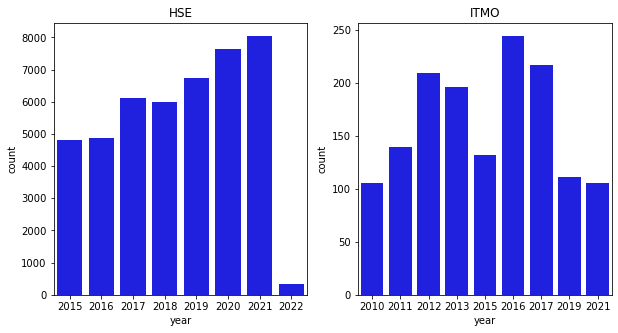

In [17]:
fig, (hse_ax, itmo_ax) = plt.subplots(1, 2, figsize=(10, 5))
plot_year_distriubtion(transformed_hse_df, "HSE", hse_ax)
plot_year_distriubtion(transformed_itmo_df, "ITMO", itmo_ax)

In [18]:
print("HSE programmes:", transformed_hse_df["educational_programme"].nunique())
print("ITMO programmes:", transformed_itmo_df["educational_programme"].nunique())
print()

print("HSE faculties:", transformed_hse_df["faculty"].nunique())
print("ITMO faculties:", transformed_itmo_df["faculty"].nunique())
print()

HSE programmes: 261
ITMO programmes: 224

HSE faculties: 47
ITMO faculties: 281



In [19]:
def count_diplomas_by_programme(df: pd.DataFrame, first_n: int = 10):
    groups = df[["educational_programme", "title"]].groupby("educational_programme").count()
    groups = groups.sort_values(by="title", ascending=False)
    print(groups[:first_n])

In [20]:
print("HSE top programmes:")
count_diplomas_by_programme(transformed_hse_df)
print()

print("ITMO top programmes:")
count_diplomas_by_programme(transformed_itmo_df)
print()

HSE top programmes:
                                            title
educational_programme                            
Экономика                                    3658
Юриспруденция                                3177
Менеджмент                                   3022
Бизнесинформатика                            2105
Дизайн                                       1253
Государственное и муниципальное управление   1236
Мировая экономика                            1095
Логистика и управление цепями поставок       1049
Социология                                   1044
Реклама и связи с общественностью             899

ITMO top programmes:
                                        title
educational_programme                        
Оптотехника                               130
Приборостроение                           101
Техническая физика                         87
Информатика и вычислительная техника       83
Фотоника и оптоинформатика                 67
Прикладная математика и информатика 